In [1]:
# Libraries Imports
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
# Loading the dataset
df = pd.read_csv('/Users/diegolemos/Masters/ML/CA2/cleaned_twcs_csv')

In [5]:
# Checking dataset information
print("Dataset shape: ", df.shape)
df.head()

Dataset shape:  (2811774, 10)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id,conversation_id,message_length,clean_text
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,3.0,121,i understand i would like to assist you we wou...
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0,1.0,45,and how do you propose we do that
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,4.0,82,i have sent several private messages and no on...
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,5.0,124,please send us a private message so that we ca...
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,6.0,18,i did


### VADER

In [6]:
# Initialising Vader
nltk.download('vader_lexicon')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/diegolemos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
# Defyning Sentiment Classification Function
def vader_sentiment(text):
    if not isinstance(text, str):
        return 'neutral'
    score = vader.polarity_scores(text)['compound']
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

In [8]:
# Filtering customer messages
df_customer = df[df['inbound'] == True].copy()

In [9]:
# Applying Vader to clean customer messages
df_customer['vader_sentiment'] =  df_customer['clean_text'].apply(vader_sentiment)

In [10]:
#Checking Distribution
df_customer['vader_sentiment'].value_counts() 

vader_sentiment
positive    580472
negative    490783
neutral     466588
Name: count, dtype: int64

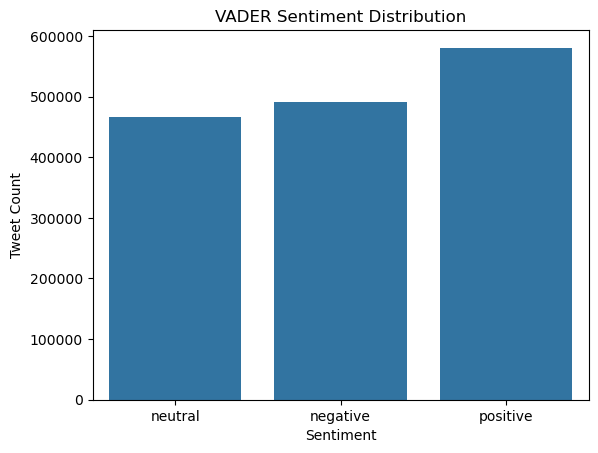

In [11]:
# Plotting Sentiment Distribution
sns.countplot(data=df_customer, x='vader_sentiment')
plt.title('VADER Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Tweet Count')
plt.show()


#### Insight
To beggin with the sentiment labelling, we have applied the VADER (Valence Aware Dictionary and sEntiment Reasoner), a lexcon and rule-based sentiment analysis tool. It was used on customer messages especifically, those where  'inbound' was equal (==) to 'True'. The VADER logic classifies  as positive if compound score is >= 0.05, negative  if it is <= -0.05 and neutral otherwise.

This labelling step is part of this projects' weak sepervision strategy, where we are goint to assign sentiment label to unlabelled customer messages, these labels will be later used directly for model training (ML and DL), compered with labels from transformer-based models like DistilBERT and refine with human review.

### DistilBERT

In [12]:
# Loading Pre-Trained DistilBERT
classifier = pipeline('sentiment-analysis', model = 'distilbert-base-uncased-finetuned-sst-2-english', framework = 'pt')

Device set to use mps:0


In [ ]:
# Applying DistilBERT Sentiment Classification On The Dataset

# Making sure all text is string
df_customer['clean_text'] = df_customer['clean_text'].astype(str)


def distilbert_sentiment_batch(texts, batch_size=128):
    result = []
    for i in tqdm(range(0, len(texts), batch_size), desc="DistilBERT Sentiment"):
        batch = texts[i: i + batch_size].tolist()
        outputs = classifier(batch)
        result.extend([output['label'].lower() for output in outputs])
    return result

# Splitting dataset into chunks
chunk_size = len(df_customer) // 4
chunks = [df_customer.iloc[i:i+chunk_size] for i in range(0, len(df_customer), chunk_size)]

# Applying the sentiment and saving each chunk
for idx, chunk in enumerate(chunks):
    print(f"\n Processing chunk {idx+1}/{len(chunks)}")
    chunk['distilbert_sentiment'] = distilbert_sentiment_batch(chunk['clean_text'])
    chunk.to_csv(f"distilbert_chunk_{idx+1}.csv", index=False)
    
# Recombining the chunks into a full dataset
df_customer = pd.concat([pd.read_csv(f"distilbert_chunk_{i+1}.csv") for i in range(len(chunks))], ignore_index=True)


In [14]:
# Loading the chunks
df_chunks = [pd.read_csv(f"distilbert_chunk_{i+1}.csv") for i in range(5)]

# Merging chunks
df_customer = pd.concat(df_chunks, ignore_index=True)

print(df_customer.columns)
print(df_customer[['clean_text', 'distilbert_sentiment']].head())

Index(['tweet_id', 'author_id', 'inbound', 'created_at', 'text',
       'response_tweet_id', 'in_response_to_tweet_id', 'conversation_id',
       'message_length', 'clean_text', 'vader_sentiment',
       'distilbert_sentiment'],
      dtype='object')
                                          clean_text distilbert_sentiment
0                  and how do you propose we do that             positive
1  i have sent several private messages and no on...             negative
2                                              i did             positive
3                      is the worst customer service             negative
4  you gonna magically change your connectivity f...             positive


In [16]:
# Saving the result
df_customer.to_csv("labelled_data.csv", index=False)
df_customer.to_pickle("labelled_data.pkl") 

In [ ]:
# Checking DistilBERT labelling
df_customer[['clean_text', 'distilbert_sentiment']].head(10)


,clean_text,distilbert_sentiment
0,and how do you propose we do that,positive
1,i have sent several private messages and no on...,negative
2,i did,positive
3,is the worst customer service,negative
4,you gonna magically change your connectivity f...,positive
5,since i signed up with yousince day 1,positive
6,yall lie about your great connection 5 bars lt...,negative
7,"whenever i contact customer support, they tell...",negative
8,would you like me to email you a copy of one s...,negative
9,i received this from your corporate office wou...,negative


#### Insight
To complement the sentiment labelling using VADER, we have also applied DistilBERT, a lightweight transformer-based language model fine-tuned for sentiment analysis (distilbert-base-uncased-finetuned-sst-2-english).

DistilBERT improves deep learnig and contextual embedding to classify messages as positive and negative with a higher level of semantic undestanding compared to a traditional lexicon-based approches.

We used DistilBERT with the objective of introduce a more context-aware perspective into the weak supervision strategy, this model has been applied to the same subset of customer message or 'inbound = true' and resulting predictions will be used to compare and potentially combine with the VADER labels to improve overall label quality.

This process is crutial for generating pseudo-lebels that will later be used for training supervised machine learning and deep learning models.

### RoBERTa

In [2]:
# Loading Pre-Treined RoBERTa 
roberta_classifier = pipeline("sentiment-analysis", model = "cardiffnlp/twitter-roberta-base-sentiment", framework = 'pt')

Device set to use mps:0


In [3]:
# Defining batch classification function
df_customer = pd.read_pickle("/Users/diegolemos/Masters/ML/CA2/labelled_data.pkl")
df_customer['clean_text'] = df_customer['clean_text'].astype(str)

def roberta_sentiment_batch(texts, batch_size=128):
    result = []
    for i in tqdm(range(0, len(texts), batch_size), desc="RoBERTa Sentiment"):
        batch = texts[i: i + batch_size].tolist()
        outputs = roberta_classifier(batch)
        result.extend([output['label'].lower() for output in outputs])
    return result

# Splitting in chuncks
chunk_size = len(df_customer) // 5
chunks = [df_customer.iloc[i:i+chunk_size].copy() for i in range(0, len(df_customer), chunk_size)]

# List of completed chunks, automatically detected
completed_chunks = [i + 1 for i in range(len(chunks)) if os.path.exists(f"roberta_chunk_{i+1}.csv")]

# Running and saving the chunks
for idx, chunk in enumerate(chunks):
    chunk_id = idx + 1
    if chunk_id in completed_chunks:
        print(f" Skipping already processed chunk {chunk_id}")
        continue

    print(f"\n Processing RoBERTa chunk {chunk_id}/{len(chunks)}")
    chunk['roberta_sentiment'] = roberta_sentiment_batch(chunk['clean_text'])
    chunk.to_csv(f"roberta_chunk_{idx+1}.csv", index=False)
    
# Recombining the chunks into a full dataset
df_roberta_chunks = [pd.read_csv(f"roberta_chunk_{chunk_id}.csv") for i in range(len(chunks))]
df_customer = pd.concat(df_roberta_chunks, ignore_index=True)

# Saving the update dataframe
df_customer.to_csv("labelled_data_with_roberta.csv", index=False)
df_customer.to_pickle("labelled_data_with_roberta.pkl")

 Skipping already processed chunk 1

 Processing RoBERTa chunk 2/6


RoBERTa Sentiment: 100%|██████████| 2403/2403 [1:33:49<00:00,  2.34s/it]



 Processing RoBERTa chunk 3/6


RoBERTa Sentiment: 100%|██████████| 2403/2403 [1:33:13<00:00,  2.33s/it]



 Processing RoBERTa chunk 4/6


RoBERTa Sentiment: 100%|██████████| 2403/2403 [1:36:31<00:00,  2.41s/it]



 Processing RoBERTa chunk 5/6


RoBERTa Sentiment: 100%|██████████| 2403/2403 [1:40:04<00:00,  2.50s/it]



 Processing RoBERTa chunk 6/6


RoBERTa Sentiment: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]


#### Note
The file 'labelled_data_with_roberta.pkl' was not saved properly, so we will need to recover the RoBERTa labelling.

In [38]:
# Loading RoBERTa chunks
roberta_chunks = [pd.read_csv(f'roberta_chunk_{i+1}.csv') for i in range(6)]

# Concatenating in a full Dataframe
df_customer = pd.concat(roberta_chunks, ignore_index = True)

# Checking full dataset
print(f'Total rows after recombining: {len(df_customer)}')
print(f'RoBERTa unique labels: {df_customer['roberta_sentiment'].unique()}')

Total rows after recombining: 1537843
RoBERTa unique labels: ['label_1' 'label_0' 'label_2']


In [39]:
#  Mapping RoBERTa labels

# Normalizing text to lowercase
df_customer['roberta_sentiment'] = df_customer['roberta_sentiment'].astype(str).str.strip().str.lower()

# Mapping numeric labels to sentiment
map_label = {
    'label_0' : 'negative',
    'label_1' : 'neutral',
    'label_2' : 'positive' 
}

df_customer['roberta_sentiment'] = df_customer['roberta_sentiment'].map(map_label)

# Checking resilts
print(df_customer['roberta_sentiment'].value_counts(dropna = False))

roberta_sentiment
negative    722823
neutral     600990
positive    214030
Name: count, dtype: int64


In [40]:
# Saving final labelled dataset
df_customer.to_csv('labelled_data_with_roberta.csv', index = False)
df_customer.to_pickle('labelled_data_with_roberta.pkl')

In [41]:
# Checking RoBERTa labelling
df_customer[['clean_text', 'roberta_sentiment']].head(10)

,clean_text,roberta_sentiment
0,and how do you propose we do that,neutral
1,i have sent several private messages and no on...,negative
2,i did,neutral
3,is the worst customer service,negative
4,you gonna magically change your connectivity f...,neutral
5,since i signed up with yousince day 1,neutral
6,yall lie about your great connection 5 bars lt...,negative
7,"whenever i contact customer support, they tell...",negative
8,would you like me to email you a copy of one s...,neutral
9,i received this from your corporate office wou...,neutral


#### Insight
We have also used RoBERTa, another powerful transformer-based model that has been pre-trained on an extensive corpus of English text and is tailored for subsequent NLP tasks, to improve sentiment labeling even more, in particular, we employed a 'cardiffnlp/twitter-roberta-base-sentiment-based' sentiment classification pipeline.

RoBERTa performs exceptionally well on sentiment analysis tasks, especially when used for casual customer messages or social media. It is particularly well-suited for our dataset because of its pretraining on Twitter data, which improves its ability to capture subtleties, slang, and short-form language.

Label_0, label_1, and label_2 are the sentiment labels assigned by the RoBERTa classifier, these represent negative, neutral, and positive sentiments, respectively. Later, these were converted into labels that people could read.

In order expand our weak supervision approach, we employed RoBERTa as a complementary model in addition to VADER and DistilBERT. The objective was to increase label accuracy by utilizing its contextual and domain-aware knowledge. By comparing predictions from different models, inconsistencies can be found and more trustworthy pseudo-labels can be created for use in training machine learning and deep learning models later on.

### VADER VS DistilBERT VS RoBERTa Label Comparison

In [42]:
# Loading the combined dataframe
df = pd.read_pickle("labelled_data_with_roberta.pkl")
df[['vader_sentiment', 'distilbert_sentiment', 'roberta_sentiment']].head()

,vader_sentiment,distilbert_sentiment,roberta_sentiment
0,neutral,positive,neutral
1,negative,negative,negative
2,neutral,positive,neutral
3,negative,negative,negative
4,neutral,positive,neutral
